## ETK Filtering

In [1]:
import Simulator
import Observation
import Statistics
import IEWParticleFilter

## Loading simulator 

For Kalman filtering we have to be able to propagate a Gaussian distribution in time and to have access to the linear operators

In [2]:
timestamp = "2021_08_26-12_22_18"

grid, simulator = Simulator.from_file(timestamp)

## Definition of initial distribution 

The inital state is equipped with a Gaussian distribution specified by its mean and covariance. 

In [3]:
statistics = Statistics.Statistics(simulator, N_e=100)

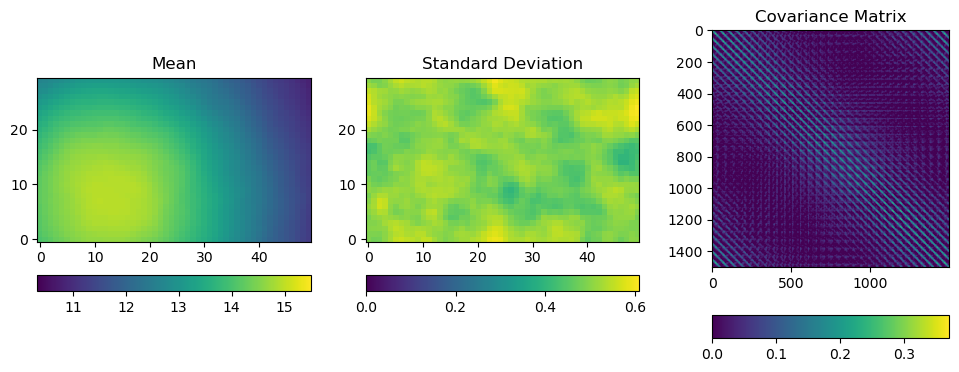

In [4]:
prior_args = Statistics.prior_args_from_file(timestamp)
statistics.set_prior(prior_args)

statistics.plot()

## Loading observations 

Observation positions which are fixed for a setup and values from the truth

In [5]:
obs_timestamp = "2021_08_26-12_22_28"
observation = Observation.from_file(grid, timestamp, obs_timestamp)

Remember to set observation positions and to set/observe values!


## IEWPF filtering

Updating/conditioning the distributions at every observation time

0


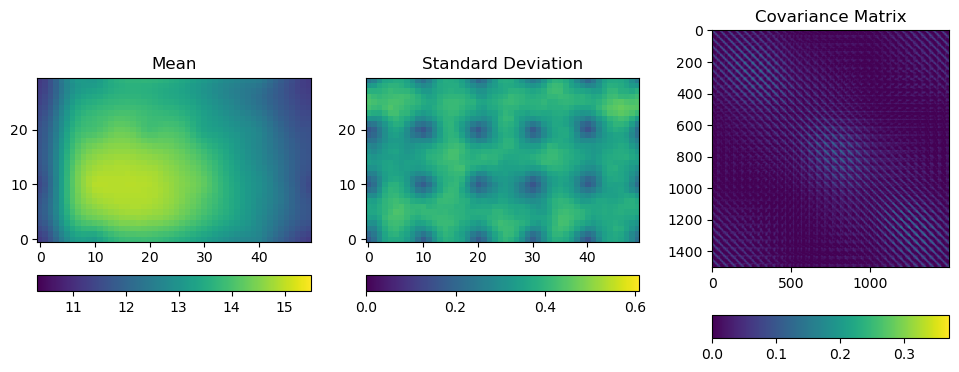

1


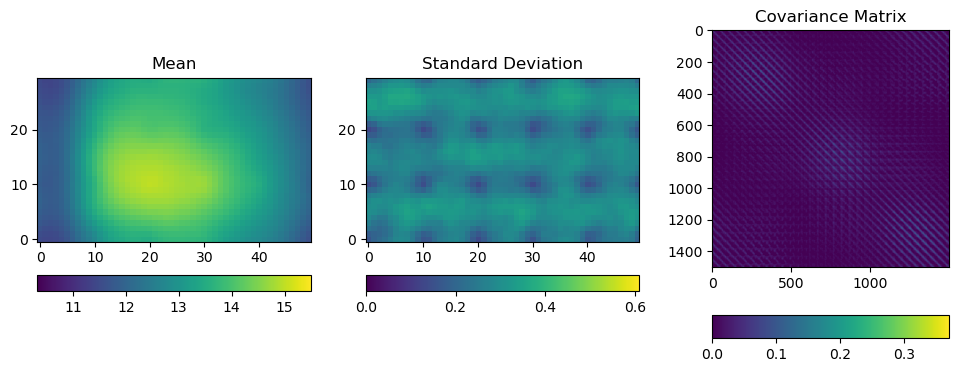

2


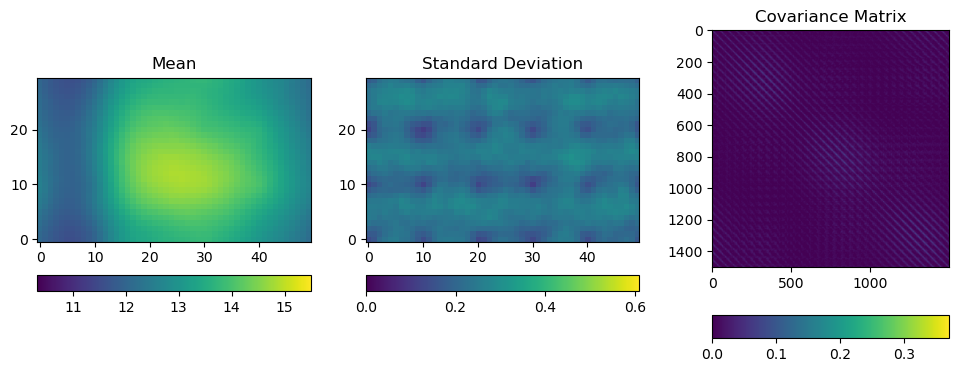

3


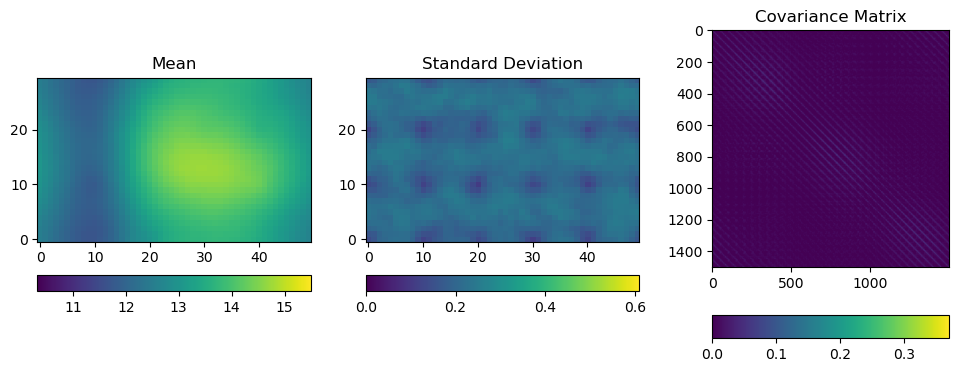

4


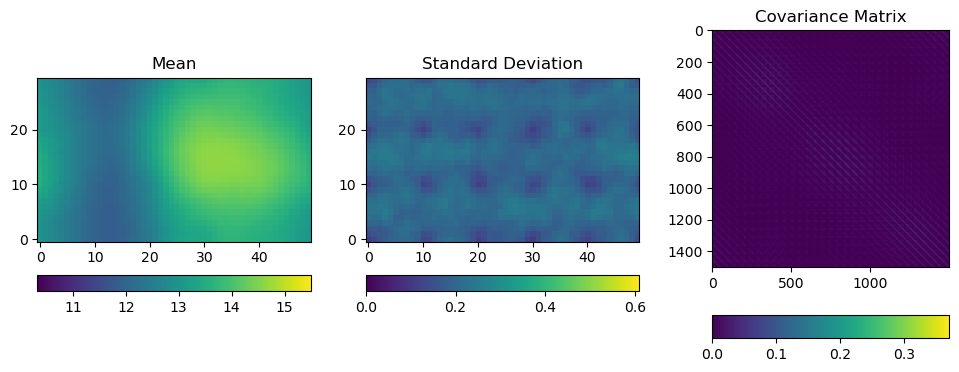

5


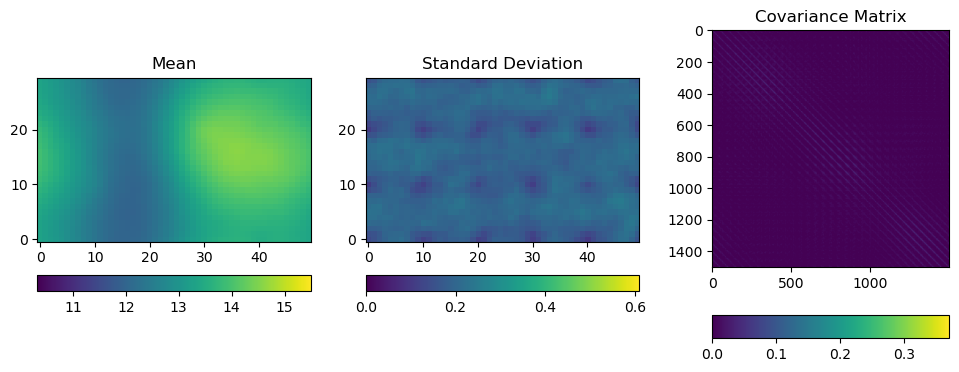

6


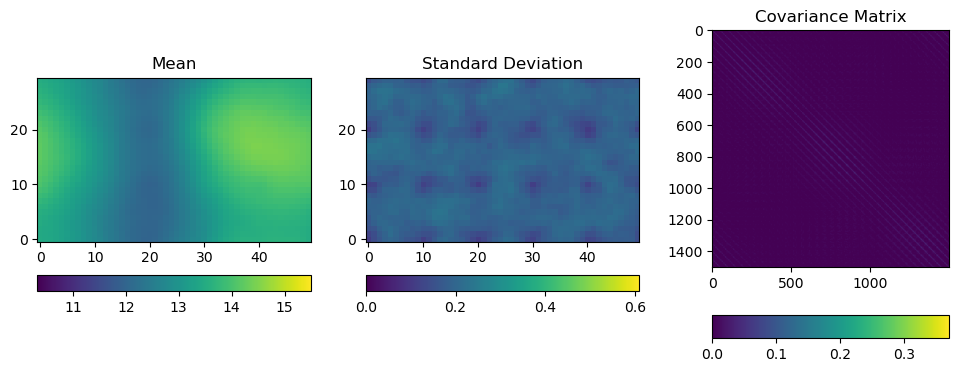

7


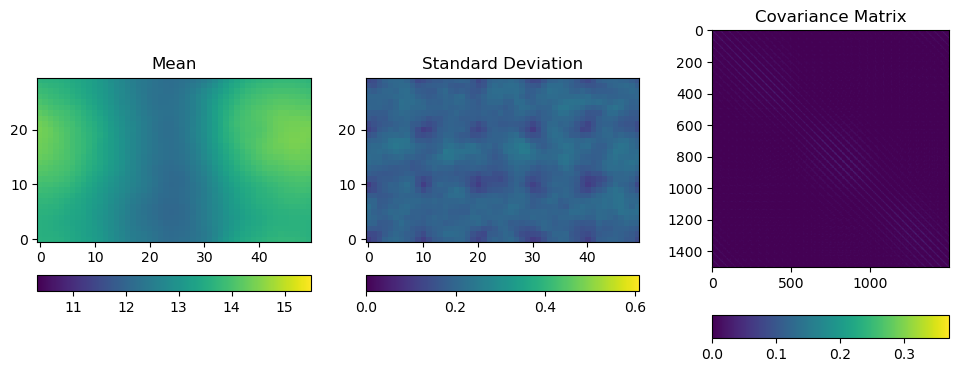

8


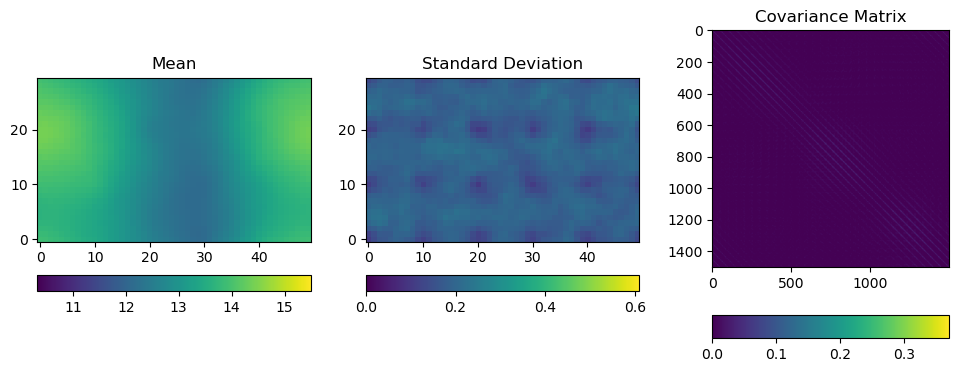

9


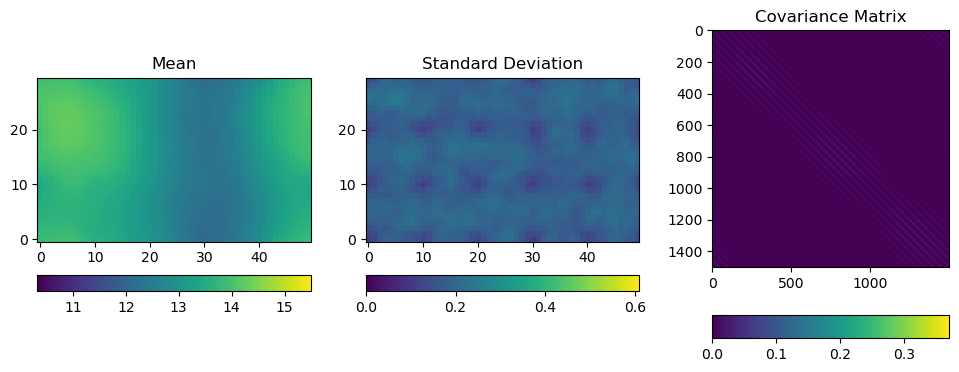

[0.880800417920845, 0.9243977836011437, 0.9605094507853396, 0.9691368119479555, 0.9804893149330347, 0.9842742799089492, 0.9831323508469995, 0.986635064057104, 0.9866445144259834, 0.9875080499985028]


In [6]:
iewpFilter = IEWParticleFilter.IEWParticle(statistics, observation)

for t in range(observation.N_obs):
    print(t)
    statistics.propagate(25, model_error=False)
    iewpFilter.filter(statistics.ensemble.ensemble, observation.obses[t])
    statistics.plot()

print(iewpFilter.betas)

In [7]:
import numpy as np
eta = np.random.standard_normal((1500,100))

In [8]:
np.diag(eta.T@eta)

array([1494.55714861, 1424.43554979, 1456.86650581, 1512.52120605,
       1421.11904124, 1627.81303669, 1551.50469921, 1518.99183256,
       1488.41786194, 1443.67193434, 1585.64427655, 1453.86525366,
       1582.93370626, 1415.64850734, 1500.21648858, 1434.01502382,
       1436.44898195, 1514.46467232, 1455.47275944, 1533.49118249,
       1373.75909918, 1427.18801959, 1479.79610925, 1440.71210009,
       1580.23788297, 1452.85510543, 1475.66071194, 1537.09646439,
       1459.620617  , 1510.69302735, 1552.50597046, 1559.43944306,
       1561.29946638, 1514.73256393, 1569.03452048, 1564.314271  ,
       1421.8400261 , 1521.52777139, 1421.15368828, 1523.19813554,
       1481.84195359, 1370.66141504, 1402.47789866, 1523.80257449,
       1481.17468776, 1485.65909339, 1564.56265209, 1468.03453588,
       1504.68191489, 1514.24932137, 1431.11012251, 1550.02494585,
       1527.8189977 , 1589.65821286, 1448.75788334, 1488.54840572,
       1493.03681573, 1429.47343128, 1621.23772372, 1548.12372